# Neural Nets 101

Goal: classify handwritten digits as **even vs odd**.

We will:

1. Load handwritten digits (8×8 grayscale images).
2. Train a logistic regression baseline (a linear classifier).
3. Train a tiny neural net with one hidden layer (fully connected + ReLU).
4. Compare test accuracy.

We will keep a validation set to watch training progress and avoid cheating.
No fancy abstractions, just NumPy, scikit-learn and PyTorch.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

print("Imports OK ✅")

Imports OK ✅


## 1. Load and inspect the data

- We use `sklearn.datasets.load_digits()`:

  - ~1800 samples
  - each image is 8×8 pixels (values 0–16)
  - label is 0..9

- We turn this into a binary label:
  - 1 if the digit is even (0,2,4,6,8)
  - 0 if the digit is odd (1,3,5,7,9)


images: (1797, 8, 8) (n_samples, 8, 8)
digit labels: (1797,)
binary even/odd labels: (1797,)


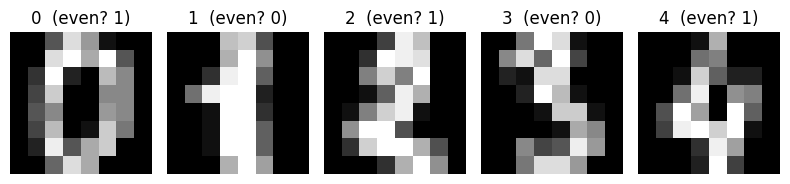

In [ ]:
digits = load_digits()
X_images = digits.images  # shape: (n_samples, 8, 8)
y_digits = digits.target  # integers 0..9

# Binary label: even -> 1, odd -> 0
y_evenodd = (y_digits % 2 == 0).astype(int)

print("images:", X_images.shape, "(n_samples, 8, 8)")
print("digit labels:", y_digits.shape)
print("binary even/odd labels:", y_evenodd.shape)

# show first 5 samples
fig, axes = plt.subplots(1, 5, figsize=(8, 2))
for ax, idx in zip(axes, range(5)):
    ax.imshow(X_images[idx], cmap="gray")
    ax.set_title(f"{y_digits[idx]}  (even? {y_evenodd[idx]})")
    ax.axis("off")
plt.tight_layout()
plt.show()

## 2. Flatten and split data

- We'll flatten each 8×8 image → vector of length 64.
- We'll split into:
  - 60% train
  - 20% validation
  - 20% test

We will:

- train only on train,
- tune / watch learning curves on validation,
- report final accuracy on test (unseen).


In [ ]:
# flatten to (n_samples, 64)
X_flat = X_images.reshape(len(X_images), -1).astype(np.float32)

# Step 1: split into train (60%) and temp (40%)
X_train, X_temp, y_train_bin, y_temp_bin, y_train_digit, y_temp_digit = (
    train_test_split(
        X_flat, y_evenodd, y_digits, test_size=0.4, random_state=42, stratify=y_evenodd
    )
)

# Step 2: split temp into val (20% total) and test (20% total)
X_val, X_test, y_val_bin, y_test_bin, y_val_digit, y_test_digit = train_test_split(
    X_temp,
    y_temp_bin,
    y_temp_digit,
    test_size=0.5,
    random_state=43,
    stratify=y_temp_bin,
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (1078, 64)
Val:   (359, 64)
Test:  (360, 64)


## 3. Baseline model: Logistic Regression

This is basically a linear classifier in 64-D space.

We'll fit on **train**, check **validation** and **test** accuracy.
We'll keep these numbers to compare with the neural net.


Logistic Regression accuracy (val):  0.919
Logistic Regression accuracy (test): 0.908


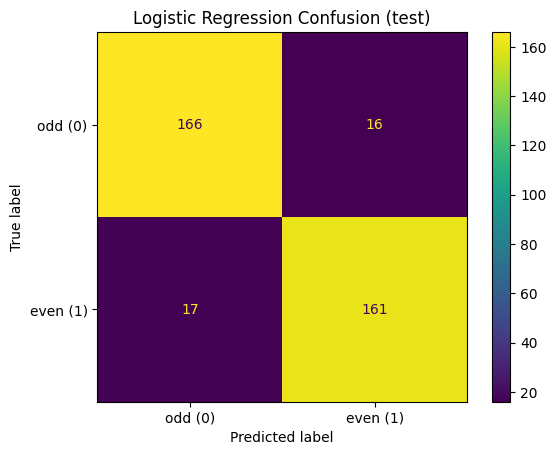

In [ ]:
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train_bin)

# predictions
y_val_pred_log = log_clf.predict(X_val)
y_test_pred_log = log_clf.predict(X_test)

val_acc_log = accuracy_score(y_val_bin, y_val_pred_log)
test_acc_log = accuracy_score(y_test_bin, y_test_pred_log)

print(f"Logistic Regression accuracy (val):  {val_acc_log:.3f}")
print(f"Logistic Regression accuracy (test): {test_acc_log:.3f}")

ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_test_pred_log, display_labels=["odd (0)", "even (1)"]
)
plt.title("Logistic Regression Confusion (test)")
plt.show()

## 4. Move data to PyTorch tensors

We'll train our own tiny neural net next,
so we convert NumPy arrays → Torch tensors.


In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_bin, dtype=torch.long)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val_bin, dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test_bin, dtype=torch.long)

print("Tensor shapes:")
print("train:", X_train_t.shape, y_train_t.shape)
print("val:  ", X_val_t.shape, y_val_t.shape)
print("test: ", X_test_t.shape, y_test_t.shape)

Tensor shapes:
train: torch.Size([1078, 64]) torch.Size([1078])
val:   torch.Size([359, 64]) torch.Size([359])
test:  torch.Size([360, 64]) torch.Size([360])


## 5. Tiny Neural Net (1 hidden layer)

We'll build a very small Multilayer Perceptron (MLP):

- Input layer: 64 numbers (the pixels)
- Hidden layer: 32 neurons, with ReLU nonlinearity
- Output layer: 2 numbers (score for class 0=odd, score for class 1=even)

We'll train it with:

- CrossEntropyLoss (classification loss)
- Adam optimizer (a smart version of gradient descent)
- Mini-batches from the training set


In [ ]:
# model = nn.Sequential(
#     nn.Linear(64, 32),    # single hidden layer
#     nn.BatchNorm1d(32),   # normalize activations
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(32, 2),
#     nn.Softmax(dim=1)      # output layer with probabilities
# )

model = nn.Sequential(
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),  # normalize activations
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 2),
    nn.Softmax(dim=1),  # output layer with probabilities
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=32, out_features=2, bias=True)
  (9): Softmax(dim=1)
)


In [74]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

6498


In [ ]:
def accuracy(model, X_t, Y_t):
    with torch.no_grad():
        logits = model(X_t)  # [N,2]
        preds = torch.argmax(logits, dim=1)
        correct = (preds == Y_t).float().mean().item()
    return correct

## 6. Training loop (mini-batch gradient descent)

- Shuffle indices
- Take mini-batches
- Compute loss, backpropagate, update weights
- Track training loss and validation accuracy each epoch
- Keep the best model (highest validation accuracy)


In [ ]:
best_val_acc = 0.0
best_weights = None

batch_size = 32
epochs = 50

train_loss_history = []
val_acc_history = []

N = X_train_t.shape[0]

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(N)
    total_loss = 0.0

    for start in range(0, N, batch_size):
        idx = perm[start : start + batch_size]
        xb = X_train_t[idx]
        yb = y_train_t[idx]

        # forward
        logits = model(xb)  # [batch,2]
        loss = loss_fn(logits, yb)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / N
    train_loss_history.append(avg_loss)

    # validation accuracy
    model.eval()
    val_acc = accuracy(model, X_val_t, y_val_t)
    val_acc_history.append(val_acc)

    # save best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = {k: v.detach().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1:02d}/{epochs}  loss={avg_loss:.4f}  val_acc={val_acc:.4f}")

print("Best validation accuracy:", best_val_acc)

# restore best weights
if best_weights is not None:
    model.load_state_dict(best_weights)

Epoch 01/50  loss=0.5908  val_acc=0.8914
Epoch 02/50  loss=0.4861  val_acc=0.9304
Epoch 03/50  loss=0.4460  val_acc=0.9443
Epoch 04/50  loss=0.4080  val_acc=0.9610
Epoch 05/50  loss=0.3939  val_acc=0.9582
Epoch 06/50  loss=0.3762  val_acc=0.9721
Epoch 07/50  loss=0.3650  val_acc=0.9721
Epoch 08/50  loss=0.3593  val_acc=0.9721
Epoch 09/50  loss=0.3567  val_acc=0.9777
Epoch 10/50  loss=0.3500  val_acc=0.9777
Epoch 11/50  loss=0.3514  val_acc=0.9749
Epoch 12/50  loss=0.3450  val_acc=0.9777
Epoch 13/50  loss=0.3551  val_acc=0.9749
Epoch 14/50  loss=0.3439  val_acc=0.9777
Epoch 15/50  loss=0.3389  val_acc=0.9805
Epoch 16/50  loss=0.3432  val_acc=0.9805
Epoch 17/50  loss=0.3334  val_acc=0.9861
Epoch 18/50  loss=0.3316  val_acc=0.9861
Epoch 19/50  loss=0.3326  val_acc=0.9777
Epoch 20/50  loss=0.3346  val_acc=0.9833
Epoch 21/50  loss=0.3322  val_acc=0.9833
Epoch 22/50  loss=0.3302  val_acc=0.9833
Epoch 23/50  loss=0.3328  val_acc=0.9805
Epoch 24/50  loss=0.3322  val_acc=0.9833
Epoch 25/50  los

Let's plot:

- training loss per epoch
- validation accuracy per epoch

This is your first "learning curve" for a neural net 🎉


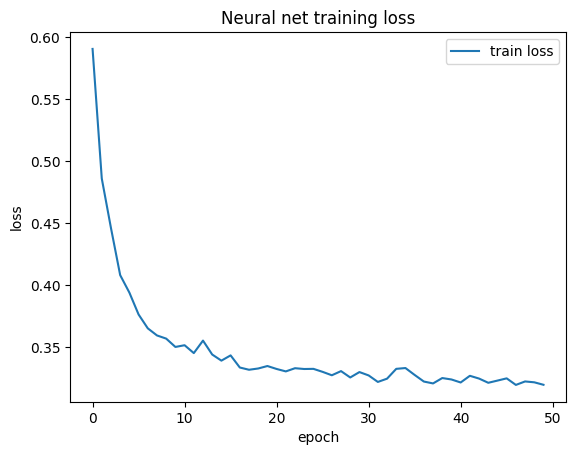

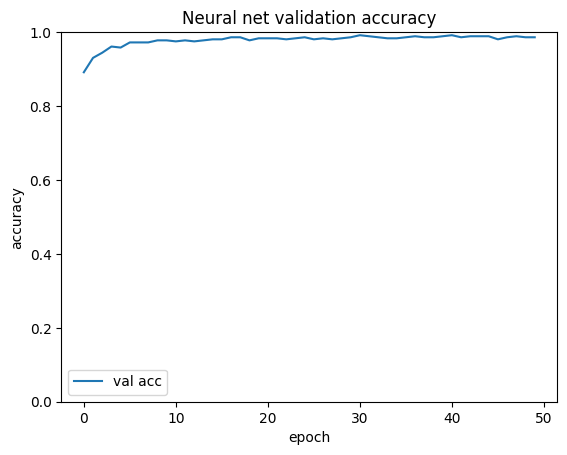

In [ ]:
plt.figure()
plt.plot(train_loss_history, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Neural net training loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_acc_history, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.title("Neural net validation accuracy")
plt.legend()
plt.show()

## 7. Final test accuracy and confusion matrix

We now evaluate on the test set for the first time.
We'll also compare the neural net against logistic regression.


Neural Net accuracy (test): 0.989
Logistic Regression accuracy (test): 0.908


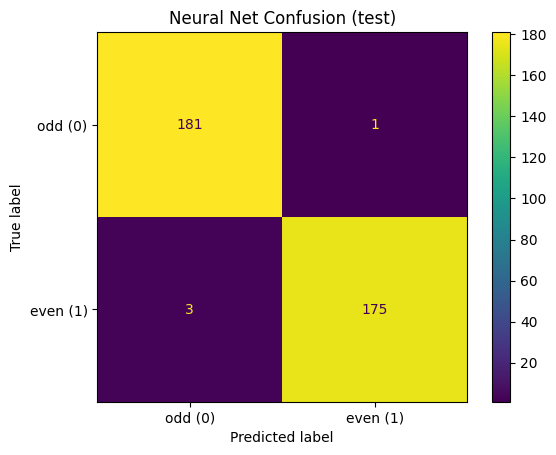

In [ ]:
model.eval()
test_acc_nn = accuracy(model, X_test_t, y_test_t)
print(f"Neural Net accuracy (test): {test_acc_nn:.3f}")
print(f"Logistic Regression accuracy (test): {test_acc_log:.3f}")

# Confusion matrix for the neural net
with torch.no_grad():
    logits_test = model(X_test_t)
    preds_test = torch.argmax(logits_test, dim=1).numpy()

ConfusionMatrixDisplay.from_predictions(
    y_test_bin, preds_test, display_labels=["odd (0)", "even (1)"]
)
plt.title("Neural Net Confusion (test)")
plt.show()

### Wrap-up talking points

- Logistic regression is a _linear_ separator in pixel space.
- The neural net adds a hidden layer → it learns an internal representation before making the final decision.
- We watched loss go down and validation accuracy go up across epochs: that's gradient descent in action.
- Test accuracy tells us how well we generalize to new digits we never trained on.
- If the neural net beats logistic regression, nonlinearity helped.
- If they tie, it means the boundary was already almost linearly separable. That's actually cool.
